<a href="https://colab.research.google.com/github/hoanbklucky/model_interpretability_using_Captum/blob/test/Captum_Recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Model Interpretability using Captum
===================================


Captum helps you understand how the data features impact your model
predictions or neuron activations, shedding light on how your model
operates.

Using Captum, you can apply a wide range of state-of-the-art feature
attribution algorithms such as `Guided GradCam` and
`Integrated Gradients` in a unified way.

In this recipe you will learn how to use Captum to:

-   Attribute the predictions of an image classifier to their
    corresponding image features.
-   Visualize the attribution results.


Before you begin
================


Make sure Captum is installed in your active Python environment. Captum
is available both on GitHub, as a `pip` package, or as a `conda`
package. For detailed instructions, consult the installation guide at
<https://captum.ai/>


For a model, we use a built-in image classifier in PyTorch. Captum can
reveal which parts of a sample image support certain predictions made by
the model.


In [2]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
import torchvision
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from IPython import display

model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).eval()

center_crop = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
])

normalize = transforms.Compose([
    transforms.ToTensor(),               # converts the image to a tensor with values between 0 and 1
    transforms.Normalize(                # normalize to follow 0-centered imagenet pixel RGB distribution
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
    )
])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


In [31]:
#url = "https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg"
#url = "https://img.freepik.com/free-photo/view-cute-dog-sleeping-bed_23-2150676243.jpg"
#url = "https://img.freepik.com/free-photo/portrait-beautiful-brown-white-domestic-australian-shepherd-dog-posing-nature-sunset_181624-59364.jpg"
#url = "https://img.freepik.com/free-photo/full-shot-woman-with-cute-greyhound-dog_23-2150231886.jpg"
#url = "https://img.freepik.com/free-photo/couple-sits-windowsill-kisses-girl-beige-outfit-hugging-guy-while-their-labrador-is-lying-rug_197531-13728.jpg"
url = "https://img.freepik.com/free-photo/woman-sitting-home-sofa-with-her-dog_23-2149392608.jpg"

In [32]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))
input_img = normalize(center_crop(img)).unsqueeze(0)

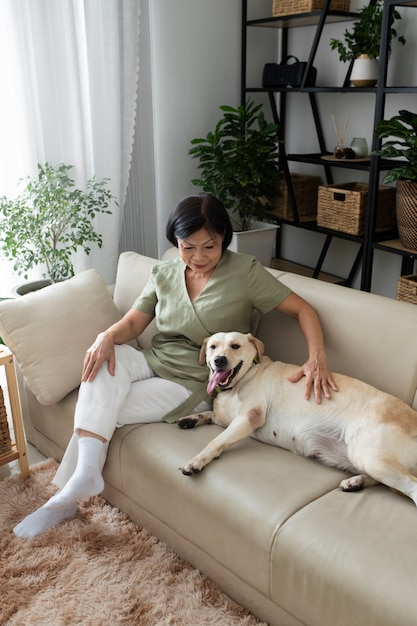

In [33]:
display.Image(url)

In [34]:
# prompt: pytorch model prediction from input image
model_prediction = model(input_img)
#print(type(model_prediction.detach().numpy()))
model_prediction_numpy = model_prediction.detach().numpy()
# index of the top 3 predictions
index_of_top3 = model_prediction_numpy[0].argsort()[-3:]
print(index_of_top3)


[162 257 208]


Computing Attribution
=====================


Among the top-3 predictions of the models are classes 231 and 232 which
correspond to collie and Border collie https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/.

Let us attribute each of these predictions to the corresponding part of
the input, using Captum's `Occlusion` algorithm.


In [35]:
from captum.attr import Occlusion

occlusion = Occlusion(model)

strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
target=index_of_top3[-2],                       # collie index in ImageNet
sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_1 = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)


target=index_of_top3[-1],                       # Border collie index in ImageNet
attribution_2 = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=0)

Besides `Occlusion`, Captum features many algorithms such as
`Integrated Gradients`, `Deconvolution`, `GuidedBackprop`,
`Guided GradCam`, `DeepLift`, and `GradientShap`. All of these
algorithms are subclasses of `Attribution` which expects your model as a
callable `forward_func` upon initialization and has an `attribute(...)`
method which returns the attribution result in a unified format.

Let us visualize the computed attribution results in case of images.


Visualizing the Results
=======================


Captum's `visualization` utility provides out-of-the-box methods to
visualize attribution results both for pictorial and for textual inputs.


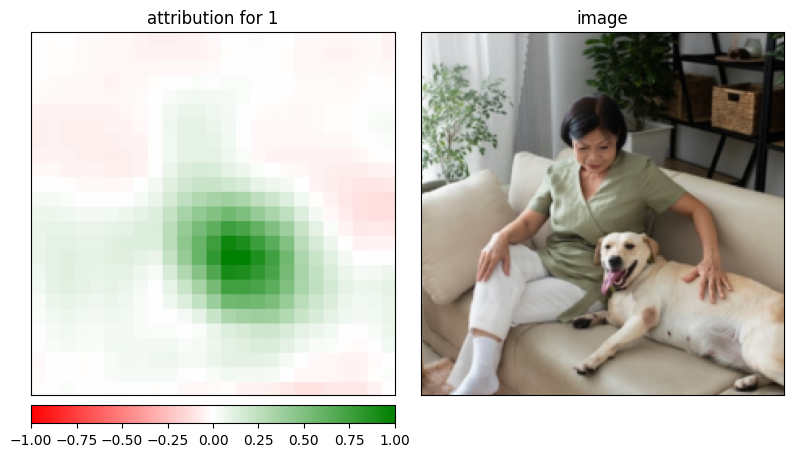

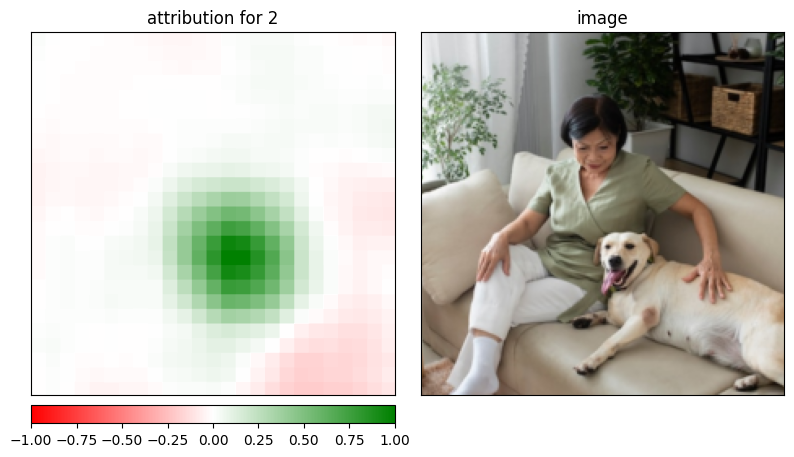

In [36]:
import numpy as np
from captum.attr import visualization as viz

# Convert the compute attribution tensor into an image-like numpy array
attribution_1 = np.transpose(attribution_1.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score

_ = viz.visualize_image_attr_multiple(attribution_1,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ["attribution for 1", "image"],
                                      show_colorbar = True
                                     )


attribution_2 = np.transpose(attribution_2.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_2,
                                      np.array(center_crop(img)),
                                      ["heat_map", "original_image"],
                                      ["all", "all"], # positive/negative attribution or all
                                      ["attribution for 2", "image"],
                                      show_colorbar = True
                                     )

If your data is textual, `visualization.visualize_text()` offers a
dedicated view to explore attribution on top of the input text. Find out
more at <http://captum.ai/tutorials/IMDB_TorchText_Interpret>


Final Notes
===========


Captum can handle most model types in PyTorch across modalities
including vision, text, and more. With Captum you can: \* Attribute a
specific output to the model input as illustrated above. \* Attribute a
specific output to a hidden-layer neuron (see Captum API reference). \*
Attribute a hidden-layer neuron response to the model input (see Captum
API reference).

For complete API of the supported methods and a list of tutorials,
consult our website <http://captum.ai>

Another useful post by Gilbert Tanner:
<https://gilberttanner.com/blog/interpreting-pytorch-models-with-captum>
